# Noiseless simulation of the FSL method for piece-wise continuous functions

In this notebook, we review how to load piece-wise continuous functions using the FSL method and perform the simulation of loading a specific piece-wise continuous function.

We first import useful libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Qiskit 
import qiskit
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit.library import QFT

# Custom libraries
import supplementary
import uniformly_controlled_rotations as UCR

It is known that large oscillations appear in the truncated Fourier series approximation of piece-wise continuous functions. These oscillations are known as the Gibbs phenomenon. These large oscillations can be suppressed by applying Fourier filters, such as Lanczos filters, that amount to scaling factors applied to the original Fourier coefficients. For example, we can modify the Fourier coefficients as $c_{k} \to \big(\text{sinc}(\pi k/M)\big)^{a} c_{k} \, $, where $a$ is a positive number and $M$ is the order of the truncated Fourier series. A nice feauture of the FSL method is that it can easily incorporate these Fourier filters. In particular, once we find the Fourier coefficients of the target function, we modify them by multiplying them with the filtering function, and then load the filtered Fourier coefficients using the cascade of uniformly controlled rotations.

## Example

We now use the above method to perform the simulation of loading the following piece-wise discontinuous function on a quantum state of $n=20$ qubits.

In [2]:
# no. of qubits 
n = 20 
# Discretizing the domain [0,1]
x = [k/(2**n) for k in range(2**n)]

# Target function
b0, b1, b2, b3 = 0.25, 0.2, 0.3, -0.05
target_f = []
for xx in x:
    if xx<0.25:
        target_f.append(b0*xx+b1)
    elif xx < 0.55:
        target_f.append(b0*xx+b2)
    else:
        target_f.append(b0*xx+b3)
target_f = target_f/np.linalg.norm(target_f)

Now we approximate the function using a Fourier series with $2^{m+1}$ Fourier terms. The first $2^{m+1}$ Fourier coefficients can be determined using the function `Fourier_state` which is defined in the code file `supplementary.py`. For concreteness, we choose $m=8$. 

In [3]:
# No. of Fourier modes
m = 8
# Fourier state |c>
state_c = supplementary.Fourier_state(target_f,m)

Now we transform the Fourier coefficients by multiplying them with the Fourier coefficients as discussed above. In this example, we take $a = 2$ in the Fourier filter. 

In [4]:
# Applying Fourier filters [c_k -> (sinc(k/M))^2 * c_k]
for k in range(1,2**m):
    state_c[k] = ((np.sin(np.pi*k/(2**m))/(np.pi*k/(2**m)))**2)*state_c[k]
    state_c[-k] = ((np.sin(np.pi*k/(2**m))/(np.pi*k/(2**m)))**2)*state_c[-k]

The rest of the code to implement the FSL method remains unchanged. That is, we first load the "filtered" Fourier coefficients on the last $m+1$ qubits, apply a cascade of CNOTs, and then apply the inverse quantum Fourier transform. 

Note that we perform the simulation using the Qiskit Aer `statevector_vector` simulator.

In [5]:
# simulator
simulator = Aer.get_backend('statevector_simulator')

# Initialize a quantum circuit
circ = QuantumCircuit(n)

# Uniformly controlled rotation
# to prepare the state |c>
U_c = UCR.cascade_UCRs(state_c)

# Apply U_c on the last (m+1) qubits
Uc_qubits = range(n-m-1,n)
circ.compose(U_c,qubits=Uc_qubits,inplace=True)

# Apply a cascade of CNOTs
for i in range(n-m-1):
    circ.cx(n-m-1,i)

# Finally, apply the inverse QFT.
inv_qft = QFT(num_qubits=n, inverse=True)
inv_qft = transpile(inv_qft, simulator)
circ.compose(inv_qft,qubits=range(n-1,-1,-1),inplace=True)

We now run the circuit and plot the simulated statevector. 

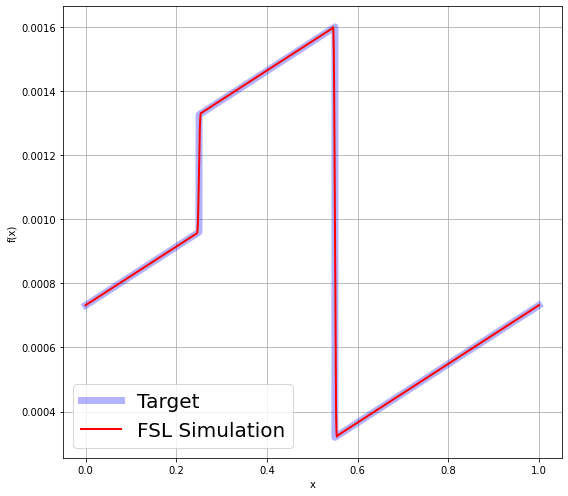

In [6]:
# Run the circuit
# and get the statevector
job = simulator.run(circ)
output_state = job.result().get_statevector(circ)

# Qubit reordering
simulated_f = supplementary.output_reordering(output_state)

# Plottting the simulated statevectors 
fig=plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
plt.grid()
line, = ax.plot(x, target_f, 'blue', lw=7, alpha=0.3,label='Target')
line1, = ax.plot(x, np.real(simulated_f), 'red', lw=2,label='FSL Simulation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc=3,fontsize=20)
plt.tight_layout()
plt.show()

Finally, we calculate the infidelity, $1 - |\langle f_{FSL}|f_{target}\rangle|^2$, between the target state and the simulated state.

In [7]:
# Calculate infidelity
infidelity = 1 - np.abs(np.dot(np.conjugate(simulated_f),target_f))**2
print(infidelity)

0.0007348920174424789


## Conclusion

In this notebook, we have shown how to load a piece-wise continuous function using the FSL method.